# Importación de Librebrías

In [45]:
!pip install keras

import keras
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, date
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.activations import softmax,tanh
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

# Carga y Limpieza de la Base de Datos

In [31]:
baseDatos = pd.read_csv("/content/clnData_1.csv")

baseDatos = baseDatos.drop_duplicates()

# Codificación de Tipos de Datos

In [3]:
#A cada mes se le da un valor entre 1 y 12

MESES = {'enero':1/12,'febrero':2/12,'marzo':3/12,'abril':4/12,'mayo':5/12,'junio':6/12,'julio':7/12,'agosto':8/12,'septiembre':9/12,'octubre':10/12,'noviembre':11/12,"diciembre":1}

baseDatos.dropna(inplace = True,subset=['fecha_hecho','hora_hecho','latitud', 'longitud'])
baseDatos = baseDatos.apply(lambda x: x.astype(str).str.lower())
baseDatos['mes_hecho'] = baseDatos['mes_hecho'].map(MESES)

#Se crean tres columnas: hora, minuto y segundo

tiemposStr = baseDatos.loc[:,["hora_hecho","fecha_hecho"]]
tiemposDate = [[],[],[]]
fueDiaFestivo = []
fueFinSemana = []
dias = []

#Días festivos
diasFestivos = [
    datetime(2024, 1, 1),   # Año Nuevo
    datetime(2024, 2, 5),   # Aniversario de la Constitución de 1917
    datetime(2024, 3, 18),  # Natalicio de Benito Juárez
    datetime(2024, 5, 1),   # Día Internacional de los Trabajadores
    datetime(2024, 6, 2),   # Elecciones federales y locales
    datetime(2024, 9, 16),  # Día de la Independencia
    datetime(2024, 10, 1),  # Día de la transmisión del Poder Ejecutivo Federal
    datetime(2024, 11, 18), # Día de la Revolución Mexicana
    datetime(2024, 12, 25)  # Navidad
]

for i in range(len(tiemposStr.index)):
  tiempo = datetime.strptime(tiemposStr.iloc[i]['hora_hecho'], '%H:%M:%S')
  tiemposDate[0].append(tiempo.hour/23)
  tiemposDate[1].append(tiempo.minute/59)
  tiemposDate[2].append(tiempo.second/59)

  fecha = datetime.strptime(tiemposStr.iloc[i].loc['fecha_hecho'], '%Y-%m-%d')

  if(fecha.weekday() > 4):
    fueFinSemana.append(1)
  else:
    fueFinSemana.append(0)

  dias.append((fecha.weekday()+1) / 7)

  fecha = fecha.replace(2024)

  if fecha in diasFestivos:
    fueDiaFestivo.append(1)
  else:
    fueDiaFestivo.append(0)

baseDatos["fueDiaFestivo"] = fueDiaFestivo
baseDatos["hora_hecho"] = tiemposDate[0]
baseDatos["minutos_hecho"] = tiemposDate[1]
baseDatos["segundos_hecho"] = tiemposDate[2]
baseDatos["finSemana"] = fueFinSemana
baseDatos['dia_hecho'] = dias

# Tratamiento de Datos para Entrenamiento

In [4]:
def circularizar(a : float):
  x = (np.sin(2 * np.pi * a) + 1) / 2
  y = (np.cos(2 * np.pi * a) + 1) / 2
  return x, y

datosCircularizar = ['mes_hecho','dia_hecho','hora_hecho','minutos_hecho','segundos_hecho']

mesesCirculares = []
diasCirculares = []

for datoCircularizar in datosCircularizar:
  baseDatos.loc[:,f'{datoCircularizar}_seno'] = baseDatos.loc[:,datoCircularizar].map(lambda x: circularizar(float(x))[0])
  baseDatos.loc[:,f'{datoCircularizar}_coseno'] = baseDatos.loc[:,datoCircularizar].map(lambda x: circularizar(float(x))[1])
  del baseDatos[datoCircularizar]

del baseDatos['fecha_hecho']
del baseDatos['agencia']


In [5]:
cambiarDatosNumerico = ['anio_hecho','latitud','longitud']

for cambiarDato in cambiarDatosNumerico:
  baseDatos[cambiarDato] = pd.to_numeric( baseDatos[cambiarDato])
print(baseDatos.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1048280 entries, 0 to 1048574
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   id                     1048280 non-null  object 
 1   anio_hecho             1048280 non-null  float64
 2   delito                 1048280 non-null  object 
 3   categoria_delito       1048280 non-null  object 
 4   fiscalia               1048280 non-null  object 
 5   unidad_investigacion   1048280 non-null  object 
 6   colonia_hecho          1048280 non-null  object 
 7   alcaldia_hecho         1048280 non-null  object 
 8   latitud                1048280 non-null  float64
 9   longitud               1048280 non-null  float64
 10  fueDiaFestivo          1048280 non-null  int64  
 11  finSemana              1048280 non-null  int64  
 12  mes_hecho_seno         1048280 non-null  float64
 13  mes_hecho_coseno       1048280 non-null  float64
 14  dia_hecho_seno         

In [6]:
datosBorrar = ['id','delito','fiscalia','unidad_investigacion','colonia_hecho','alcaldia_hecho']

for borrar in datosBorrar:
  del baseDatos[borrar]


In [7]:
print(baseDatos.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1048280 entries, 0 to 1048574
Data columns (total 16 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   anio_hecho             1048280 non-null  float64
 1   categoria_delito       1048280 non-null  object 
 2   latitud                1048280 non-null  float64
 3   longitud               1048280 non-null  float64
 4   fueDiaFestivo          1048280 non-null  int64  
 5   finSemana              1048280 non-null  int64  
 6   mes_hecho_seno         1048280 non-null  float64
 7   mes_hecho_coseno       1048280 non-null  float64
 8   dia_hecho_seno         1048280 non-null  float64
 9   dia_hecho_coseno       1048280 non-null  float64
 10  hora_hecho_seno        1048280 non-null  float64
 11  hora_hecho_coseno      1048280 non-null  float64
 12  minutos_hecho_seno     1048280 non-null  float64
 13  minutos_hecho_coseno   1048280 non-null  float64
 14  segundos_hecho_seno    

In [8]:
categorias_delito = baseDatos.categoria_delito.unique().tolist()
jencoding = {}

for i in range(len(categorias_delito)):
  jencoding.update({categorias_delito[i]:[0 for i in range(len(baseDatos.index))]})

for i in range(len(baseDatos.index)):
  jencoding[baseDatos.iloc[i].loc["categoria_delito"]][i]=1

for delito in jencoding:
  baseDatos[delito] = jencoding[delito]

In [9]:
baseDatosEntrenamiento = baseDatos[baseDatos['anio_hecho'] >=0]
print(baseDatosEntrenamiento.iloc[0])

anio_hecho                                                                 2015.0
categoria_delito                                           delito de bajo impacto
latitud                                                                  19.30086
longitud                                                                -99.20877
fueDiaFestivo                                                                   0
finSemana                                                                       0
mes_hecho_seno                                                                0.5
mes_hecho_coseno                                                              1.0
dia_hecho_seno                                                           0.283058
dia_hecho_coseno                                                         0.049516
hora_hecho_seno                                                           0.02887
hora_hecho_coseno                                                         0.33256
minutos_hecho_se

In [48]:

X = baseDatosEntrenamiento.loc[:, baseDatosEntrenamiento.columns != 'categoria_delito']
X = X.loc[:, :'segundos_hecho_coseno']
y = baseDatosEntrenamiento.loc[:,'delito de bajo impacto':]

print(len(X.columns))
print(len(y.columns))
y.columns


15
16


Index(['delito de bajo impacto',
       'robo a pasajero a bordo de taxi con violencia',
       'robo a transeunte en vía pública con y sin violencia',
       'robo de vehículo con y sin violencia', 'homicidio doloso',
       'lesiones dolosas por disparo de arma de fuego', 'hecho no delictivo',
       'robo a negocio con violencia', 'robo a repartidor con y sin violencia',
       'robo a casa habitación con violencia',
       'robo a cuentahabiente saliendo del cajero con violencia',
       'robo a pasajero a bordo de microbus con y sin violencia',
       'robo a pasajero a bordo del metro con y sin violencia',
       'robo a transportista con y sin violencia', 'plagio o secuestro',
       'feminicidio'],
      dtype='object')

In [11]:
print(X.iloc[0])

anio_hecho               2015.000000
latitud                    19.300860
longitud                  -99.208770
fueDiaFestivo               0.000000
finSemana                   0.000000
mes_hecho_seno              0.500000
mes_hecho_coseno            1.000000
dia_hecho_seno              0.283058
dia_hecho_coseno            0.049516
hora_hecho_seno             0.028870
hora_hecho_coseno           0.332560
minutos_hecho_seno          0.473389
minutos_hecho_coseno        0.000709
segundos_hecho_seno         0.500000
segundos_hecho_coseno       1.000000
Name: 0, dtype: float64


In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

model = Sequential()

model.add(Dense(15, activation='relu'))

model.add(Dense(30, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(18, activation='relu'))

model.add(Dense(16, activation='softmax'))  # Asegúrate de que el número de neuronas coincida con las categorías

model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=2048, verbose=1, validation_data=(X_test, y_test))

Epoch 1/100
343/343 [==============================] - 3s 6ms/step - loss: 2.2758 - accuracy: 0.7380 - val_loss: 1.0234 - val_accuracy: 0.7584
Epoch 2/100
343/343 [==============================] - 2s 5ms/step - loss: 1.0206 - accuracy: 0.7570 - val_loss: 1.0107 - val_accuracy: 0.7584
Epoch 3/100
343/343 [==============================] - 2s 5ms/step - loss: 1.0251 - accuracy: 0.7570 - val_loss: 1.0142 - val_accuracy: 0.7584
Epoch 4/100
343/343 [==============================] - 2s 5ms/step - loss: 1.0209 - accuracy: 0.7570 - val_loss: 1.0188 - val_accuracy: 0.7584
Epoch 5/100
343/343 [==============================] - 2s 5ms/step - loss: 1.0227 - accuracy: 0.7570 - val_loss: 1.0129 - val_accuracy: 0.7584
Epoch 6/100
343/343 [==============================] - 2s 5ms/step - loss: 1.0735 - accuracy: 0.7523 - val_loss: 1.0102 - val_accuracy: 0.7584
Epoch 7/100
343/343 [==============================] - 2s 5ms/step - loss: 1.0158 - accuracy: 0.7570 - val_loss: 1.0145 - val_accuracy: 0.7584

In [27]:
#Exportar el modelo al explorador
model.save('numeros_conv.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Ejemplo de predicción

        delito de bajo impacto  robo a pasajero a bordo de taxi con violencia  \
822004                       1                                              0   

        robo a transeunte en vía pública con y sin violencia  \
822004                                                  0      

        robo de vehículo con y sin violencia  homicidio doloso  \
822004                                     0                 0   

        lesiones dolosas por disparo de arma de fuego  hecho no delictivo  \
822004                                              0                   0   

        robo a negocio con violencia  robo a repartidor con y sin violencia  \
822004                             0                                      0   

        robo a casa habitación con violencia  \
822004                                     0   

        robo a cuentahabiente saliendo del cajero con violencia  \
822004                                                  0         

        robo a pasajero a bor

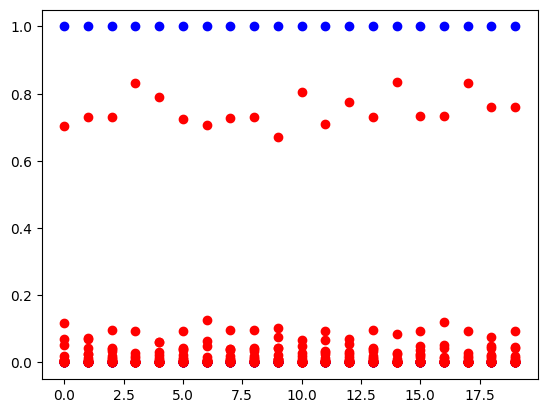

In [79]:
# Función para transformar datos de tiempo
def circularizar(a):
  x = (np.sin(2 * np.pi * a) + 1) / 2
  y = (np.cos(2 * np.pi * a) + 1) / 2
  return x, y

#Definición de parametro de ejemplo


#Predicción utilizando los parámetros definidos anteriormente


y_predicciones = model.predict(X_test.tail(20), verbose=False)


plt.plot(range(20),y_test.tail(20),'bo')
plt.plot(range(20),y_predicciones,'ro')

y_test.tail(20).columns

print(y_test.head(1))
plt.show()

#Impresión de predicción por categoría de delito realizada


In [34]:
alcaldias = {}

print(baseDatos.columns)

for i in range(len(baseDatos.index)):
    if(baseDatos.iloc[i].loc["alcaldia_hecho"] not in alcaldias):
      alcaldias.update({baseDatos.iloc[i].loc["alcaldia_hecho"] : [baseDatos.iloc[i].loc["latitud"], baseDatos.iloc[i].loc["longitud"]]})

print(alcaldias)


Index(['id', 'anio_hecho', 'mes_hecho', 'fecha_hecho', 'hora_hecho', 'delito',
       'categoria_delito', 'fiscalia', 'agencia', 'unidad_investigacion',
       'colonia_hecho', 'alcaldia_hecho', 'latitud', 'longitud'],
      dtype='object')
{'TLALPAN': [19.30086, -99.20877], 'IZTAPALAPA': [19.3408, -99.11431], 'GUSTAVO A. MADERO': [19.45106, -99.08669], 'BENITO JUAREZ': [19.38095, -99.13982], 'COYOACAN': [19.32651, -99.11497], 'MIGUEL HIDALGO': [19.45716, -99.17253], 'AZCAPOTZALCO': [19.47936, -99.17994], 'IZTACALCO': [19.3937, -99.08147], 'ALVARO OBREGON': [19.39787, -99.20915], 'CUAUHTEMOC': [19.45631, -99.15491], 'VENUSTIANO CARRANZA': [19.42718, -99.12176], 'XOCHIMILCO': [19.24623, -99.1144], 'LA MAGDALENA CONTRERAS': [19.3009, -99.25837], 'TLAHUAC': [19.22317, -98.96175], 'MILPA ALTA': [19.19197, -99.02291], 'CUAJIMALPA DE MORELOS': [19.33485, -99.31215], 'FUERA DE CDMX': [19.3121, -98.96331], nan: [19.46025, -99.21577]}


KeyError: 'anio_hecho'

,anio_hecho,latitud,longitud,fueDiaFestivo,finSemana,mes_hecho_seno,mes_hecho_coseno,dia_hecho_seno,dia_hecho_coseno,hora_hecho_seno,hora_hecho_coseno,minutos_hecho_seno,minutos_hecho_coseno,segundos_hecho_seno,segundos_hecho_coseno


In [ ]:
X = baseDatosEntrenamientoPrueba.loc[:, baseDatosEntrenamientoPrueba.columns != 'categoria_delito']
X = X.loc[:, :'segundos_hecho_coseno']
y = baseDatosEntrenamientoPrueba.loc[:,'delito de bajo impacto':]